In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow import keras
# import keras
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

CLASSES = ['trunk', 'cane', 'cordon', 'background']

# Set framework and load the model
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

# Define U-Net model with ResNet34 backbone pre-trained on ImageNet
unet_model = sm.Unet('resnet34',
                     input_shape=(288, 512, 3),
                     encoder_weights='imagenet',
                     classes=4,
                     activation='softmax')

# Compile the model
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss=sm.losses.CategoricalFocalLoss,
                   metrics=['accuracy'])

unet_model.summary()

Segmentation Models: using `tf.keras` framework.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 288, 512,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 288, 512,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 294, 518,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 144, 256,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 144, 256,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 144, 256,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 146, 258,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 72, 128,   │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 72, 128,   │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 72, 128,   │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 74, 130,   │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 72, 128,   │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 72, 128,   │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 72, 128,   │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 74, 130,   │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 72, 128,   │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 72, 128,   │      4,096 │ stage1_unit1_rel

 Total params: 24,456,589 (93.29 MB)

 Trainable params: 24,439,239 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [2]:
from PIL import Image
import numpy as np
import os

# Directories for images and masks
image_dir = 'Dataset/raw_img/'
mask_dir = 'Dataset/segmented_img/'

# Get filenames
image_filenames = sorted(os.listdir(image_dir))
mask_filenames = sorted(os.listdir(mask_dir))

# Initialize lists to store the images and masks as numpy arrays
X = list()
Y = list()

# Iterate through the filenames to load and convert images and masks
for img_file, mask_file in zip(image_filenames, mask_filenames):
    # Load image and convert to numpy array
    img = Image.open(os.path.join(image_dir, img_file)).convert('RGB')
    img = img.resize((512, 288))  # Resize as needed
    img_array = np.array(img)  # Convert to numpy array
    X.append(img_array)

    # Load mask and convert to numpy array
    mask = Image.open(os.path.join(mask_dir, mask_file))  # Ensure mask is grayscale
    mask = mask.resize((512, 288))  # Resize as needed
    mask_array = np.array(mask)  # Convert to numpy array
    Y.append(mask_array)

# Convert the lists to numpy arrays for further processing
X = np.array(X)
Y = np.array(Y)



In [3]:
print(X.shape)
print(Y.shape)

(100, 288, 512, 3)
(100, 288, 512)


In [4]:
from tensorflow.keras.utils import to_categorical

# Convert the mask labels to one-hot encoded format
Y = to_categorical(Y, num_classes=4)
print(f'Masks shape after one-hot encoding: {Y.shape}')

Masks shape after one-hot encoding: (100, 288, 512, 4)


In [5]:
# Normalize image data (scale pixel values between 0 and 1)
X = X / 255.0
X = X.astype(np.float32)  # Convert to float
# Expand the mask dimension if it's binary segmentation (single class)
Y = Y.astype(np.float32)  # Convert to float32 data type

print(f'Images shape: {X.shape}')
print(f'Masks shape: {Y.shape}')

Images shape: (100, 288, 512, 3)
Masks shape: (100, 288, 512, 4)


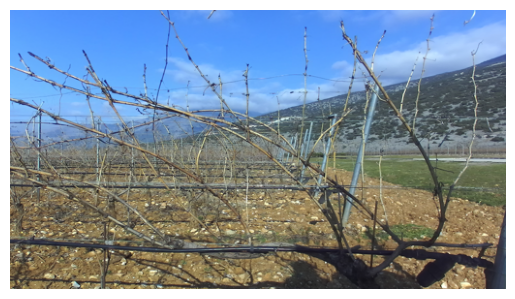

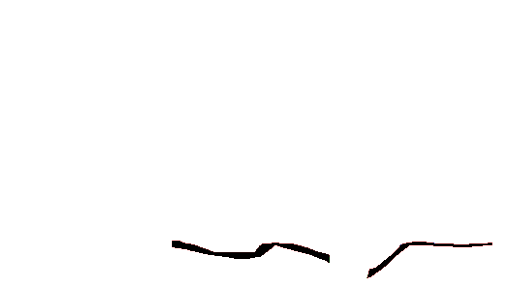

In [6]:
import matplotlib.pyplot as plt

plt.axis('off')

plt.imshow(X[1])
plt.figure()

plt.axis('off')
plt.imshow(Y[1], cmap='gray')

(288,)
(288, 288)
(288, 512)


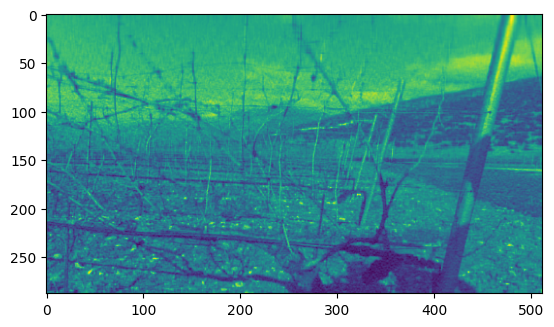

In [7]:
img = X[0].mean(axis=-1)
U, s, Vt = np.linalg.svd(img, full_matrices=False)

print(s.shape)
print(U.shape)
print(Vt.shape)

s[70:] = 0

img = U @ np.diag(s) @ Vt
plt.imshow(img)


C:\Users\hp\AppData\Local\Temp\ipykernel_11144\924770768.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  axis3d = plt.figure().gca(projection='3d')


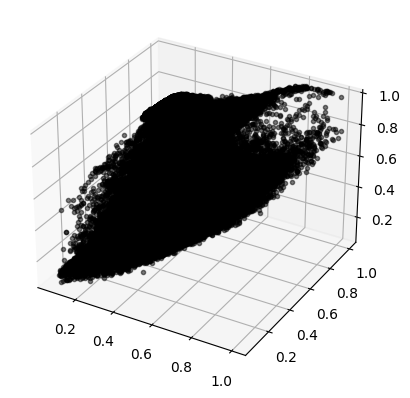

In [8]:
img = X[0]

axis3d = plt.figure().gca(projection='3d')

axis3d.plot3D(img[:, :, 0].flatten(), img[:, :, 1].flatten(), img[:, :, 2].flatten(), 'k.', alpha=0.5)

[[0.27617604 0.28668213 0.28024623]
 [0.32754734 0.5825485  0.9384005 ]
 [0.63628    0.61367214 0.4990507 ]
 [0.41153964 0.38082796 0.28559875]
 [0.482844   0.6569807  0.86624974]
 [0.6516894  0.7732053  0.88857055]
 [0.41492236 0.52220803 0.6406203 ]
 [0.17324159 0.16590557 0.17445228]
 [0.5428717  0.47889432 0.34358382]
 [0.38116083 0.42617145 0.45676777]]


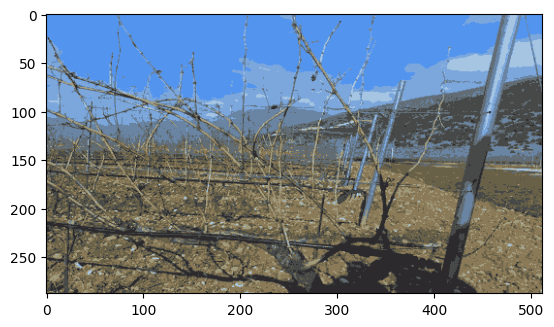

In [9]:
# try to cluster the pixels in the image

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(img.reshape(-1, 3))

print(kmeans.cluster_centers_)

img_clustered = kmeans.cluster_centers_[kmeans.labels_].reshape(img.shape)

plt.imshow(img_clustered)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [11]:
# Print shapes to check data
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (70, 288, 512, 3)
Y_train shape: (70, 288, 512, 4)
X_val shape: (15, 288, 512, 3)
Y_val shape: (15, 288, 512, 4)
X_test shape: (15, 288, 512, 3)
Y_test shape: (15, 288, 512, 4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(1, 288, 512, 4)


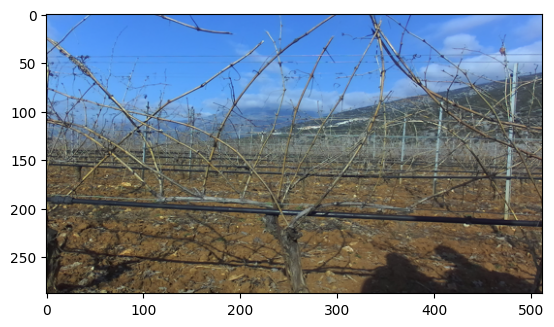

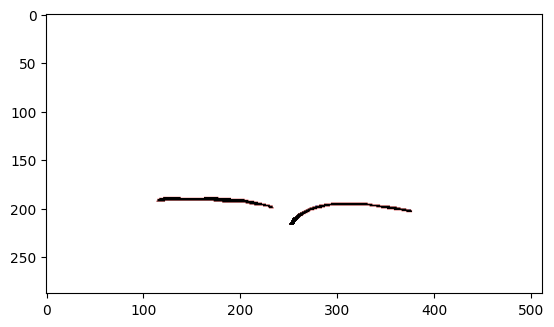

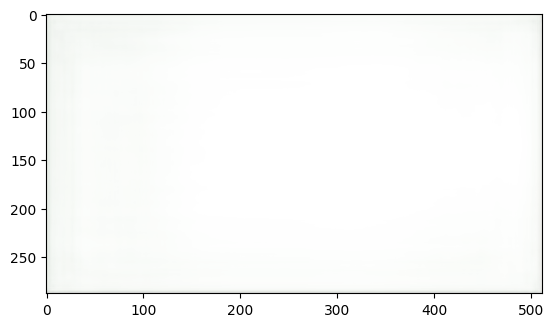

In [12]:
mask = unet_model.predict(X_train[0].reshape(1, 288, 512, 3))
print(mask.shape)
plt.imshow(X_train[0].reshape(288, 512, 3))
plt.figure()
plt.imshow(Y_train[0], cmap='gray')
plt.figure()
plt.imshow(mask[0], cmap='gray')

In [ ]:
# Image Data Generator for data augmentation
data_gen_args = dict(horizontal_flip=True,
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        brightness_range=[0.8, 1.2],
                        fill_mode='nearest')

train_datagen = ImageDataGenerator(**data_gen_args, preprocessing_function=sm.get_preprocessing('resnet34'))
test_datagen = ImageDataGenerator(preprocessing_function=sm.get_preprocessing('resnet34'))
valid_datagen = ImageDataGenerator(preprocessing_function=sm.get_preprocessing('resnet34'))
train_generator = train_datagen.flow(X_train, Y_train, batch_size=8)
valid_generator = valid_datagen.flow(X_val, Y_val, batch_size=8)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=8)


# Check if any of the generators are empty
print(f"Train generator length: {len(train_generator)}")
print(f"Valid generator length: {len(valid_generator)}")
print(f"Test generator length: {len(test_generator)}")

# Train the model
history = unet_model.fit(train_generator,
                         validation_data=valid_generator,
                         epochs=50,  # Adjust according to your needs
                         steps_per_epoch= X_train.shape[0] // 8,
                         validation_steps= X_val.shape[0] // 8,
                         verbose=1,
                         shuffle=True)

Train generator length: 9
Valid generator length: 2
Test generator length: 2
Epoch 1/50


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.8810 - loss: 0.0233 - val_accuracy: 0.0191 - val_loss: 0.0808
Epoch 2/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - accuracy: 0.9012 - loss: 0.0208

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.9012 - loss: 0.0208 - val_accuracy: 0.0148 - val_loss: 0.0794
Epoch 3/50


In [14]:
# Evaluate the model
scores = unet_model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {scores[0]}")
print(f"Test Accuracy Score: {scores[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0130 - loss: 0.1020
Test Loss: 0.10204324871301651
Test Accuracy Score: 0.012959346175193787


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
(1, 288, 512, 4)
(1, 288, 512)


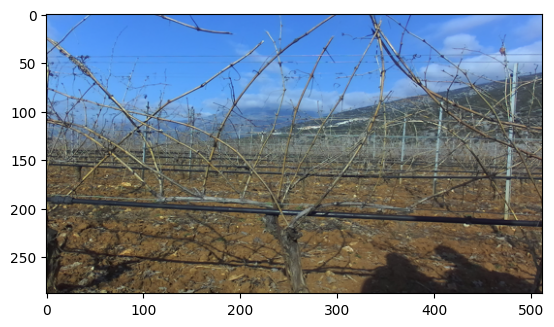

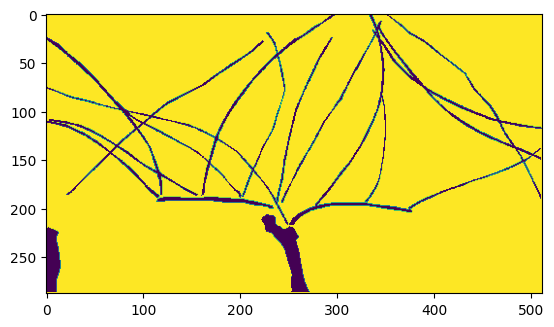

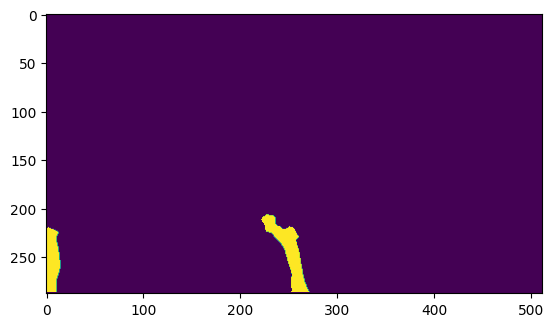

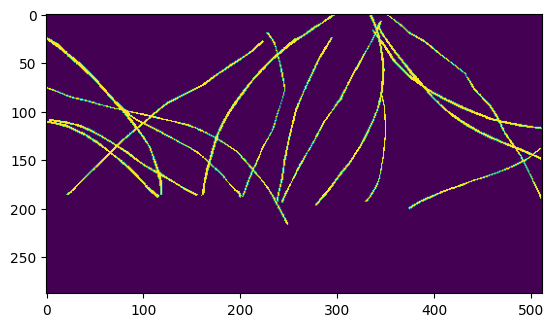

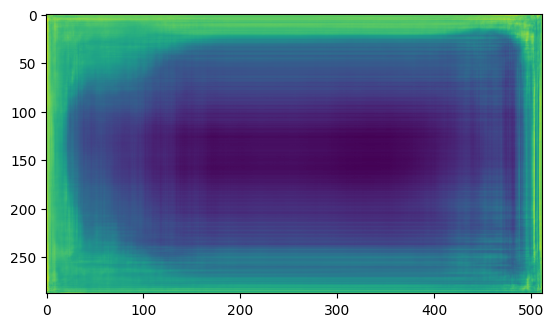

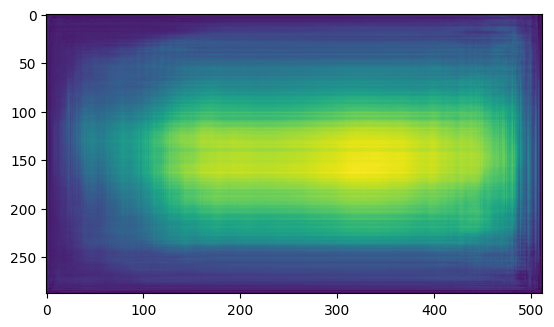

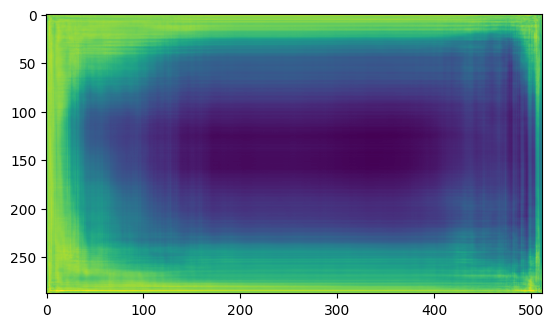

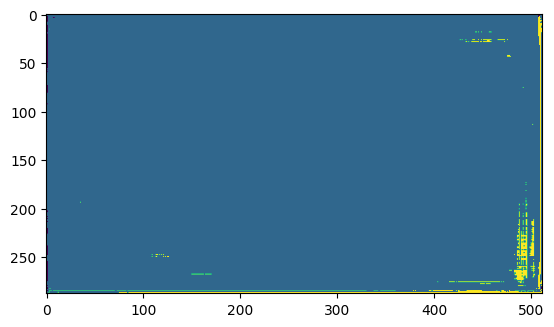

In [15]:
mask = unet_model.predict(X_train[0].reshape(1, 288, 512, 3))
mask_t = np.argmax(mask, axis=-1)

print(mask.shape)
print(mask_t.shape)

plt.imshow(X_train[0])

plt.figure()
plt.imshow(Y_train[0, :, :, 0], cmap='gray')
plt.figure()
plt.imshow(Y_train[0, :, :, 1], cmap='gray')
plt.figure()
plt.imshow(Y_train[0, :, :, 2], cmap='gray')

plt.figure()
plt.imshow(mask[0, :, :, 0], cmap='gray')
plt.figure()
plt.imshow(mask[0, :, :, 1], cmap='gray')
plt.figure()
plt.imshow(mask[0, :, :, 2], cmap='gray')

plt.figure()
plt.imshow(mask_t[0])